In [22]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModel
from scipy.stats import uniform, randint
import time
import joblib



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jhon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model Development

Este notebook se divide en dos secciones principales:

1. Selección del método de embedding
2. Selección del modelo de clasificación

## 1. Selección del Método de Embedding

Esta seccion se enfoca en la selección del mejor método de embedding para nuestro modelo de detección de textos tóxicos. Se compararán cuatro técnicas diferentes de representación de texto:

1. TF-IDF (Term Frequency-Inverse Document Frequency)
2. Word2Vec
3. FastText
4. BERT (Bidirectional Encoder Representations from Transformers)

Cada uno de estos métodos tiene sus propias ventajas y desventajas, y sera seleccionado el mejor de acuerdo con su rendimiento en nuestro conjunto de datos específico.

## 2. Selección del Modelo de Clasificación

Una vez seleccionado el mejor método de embedding, se a evaluará y comparará diferentes modelos de clasificación. Como se especifica en los requerimientos del proyecto, los modelos que se considerarán incluyen:

- Random Forest
- XGBoost
- LightGBM

Se evaluará el rendimiento y se seleccionará el que ofrezca los mejores resultados para nuestro problema de detección de textos tóxicos.

### Nota sobre el Balanceo de Datos

se ha decidido no aplicar técnicas de oversampling o undersampling para abordar el ligero desbalance en nuestro conjunto de datos. Esta decisión se basa en las siguientes consideraciones:

1. **Preservación de la distribución natural**: Mantener la distribución original nos permite modelar el problema tal como se presenta en el mundo real.

2. **Riesgos del oversampling en NLP**: El oversampling en tareas de procesamiento de lenguaje natural puede introducir redundancia y sobreajuste, especialmente si se generan muestras sintéticas que no capturan la complejidad del lenguaje natural.

3. **Pérdida de información con undersampling**: El undersampling podría resultar en la pérdida de ejemplos valiosos y matices importantes en la clase mayoritaria.

4. **Desbalance moderado**: Nuestro conjunto de datos presenta un desbalance relativamente moderado (1.50:1), que no es lo suficientemente severo como para justificar técnicas agresivas de rebalanceo.

En su lugar, abordaremos el desbalance mediante:

- Uso de métricas de evaluación apropiadas (como F1-score y AUC-ROC)
- Ajuste de los umbrales de decisión del modelo
- Ponderación de clases en el algoritmo de aprendizaje

Este enfoque nos permitirá desarrollar un modelo más robusto y generalizable, manteniendo la integridad de nuestros datos originales.

A continuación, procederemos con la implementación y comparación de los diferentes métodos de embedding.

# 1. Seleccion de Embedding

In [4]:

# Cargar los datos
df = pd.read_csv('../data/processed/data_toxic_features.csv')

# Función para obtener el vector de documento
def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluación del modelo {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()




In [6]:
# Separar características y etiquetas
X = df['lemmatized_message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizar las oraciones
X_train_tokens = [word_tokenize(text.lower()) for text in X_train]
X_test_tokens = [word_tokenize(text.lower()) for text in X_test]




Generando embeddings TF-IDF...
Evaluación del modelo TF-IDF:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     57781
           1       0.93      0.75      0.83     38637

    accuracy                           0.88     96418
   macro avg       0.89      0.86      0.87     96418
weighted avg       0.88      0.88      0.87     96418



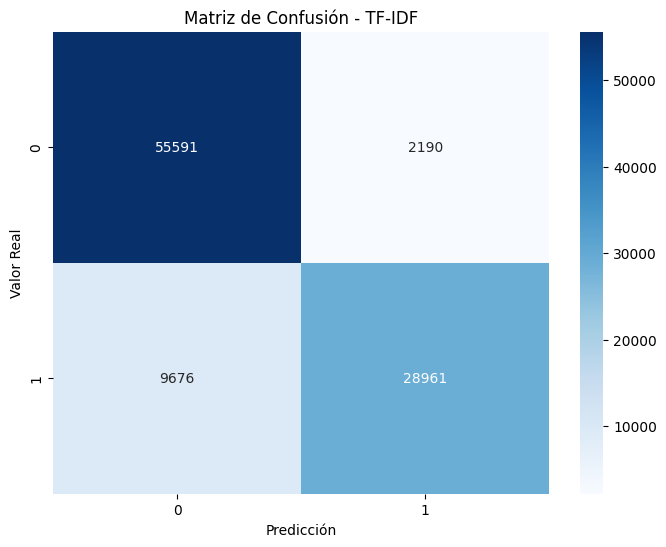

In [7]:
# 1. TF-IDF
print("Generando embeddings TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limitamos a 100 características para igualar con Word2Vec y FastText
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_model = RandomForestClassifier(n_estimators=100, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

evaluate_model(y_test, y_pred_tfidf, "TF-IDF")


Generando embeddings Word2Vec...
Evaluación del modelo Word2Vec:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.92      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     96418



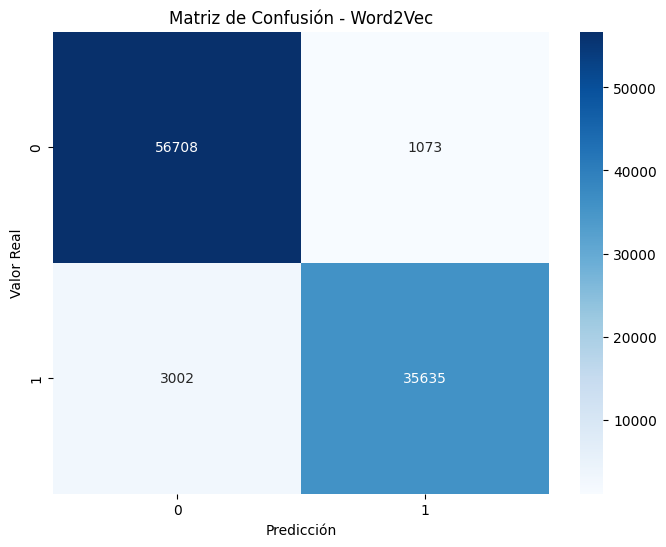

In [8]:
# 2. Word2Vec
print("Generando embeddings Word2Vec...")
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

X_train_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in X_train_tokens])
X_test_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in X_test_tokens])

w2v_clf = RandomForestClassifier(n_estimators=100, random_state=42)
w2v_clf.fit(X_train_w2v, y_train)
y_pred_w2v = w2v_clf.predict(X_test_w2v)

evaluate_model(y_test, y_pred_w2v, "Word2Vec")

Generando embeddings FastText...
Evaluación del modelo FastText:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     57781
           1       0.97      0.92      0.94     38637

    accuracy                           0.95     96418
   macro avg       0.96      0.95      0.95     96418
weighted avg       0.95      0.95      0.95     96418



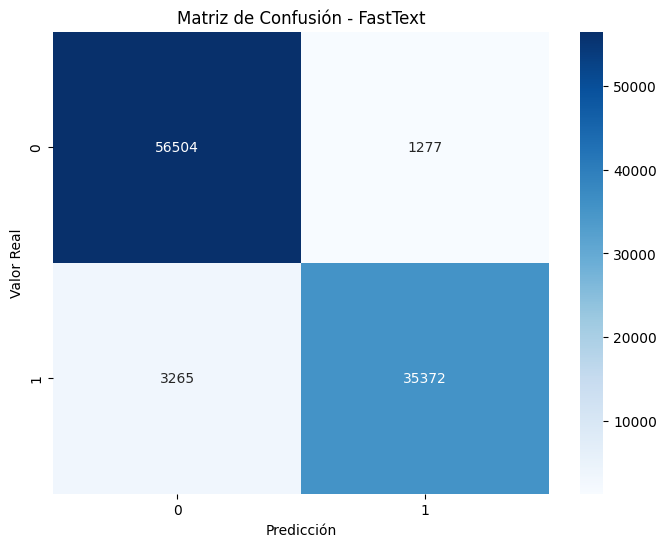

In [9]:
# 3. FastText
print("Generando embeddings FastText...")
fasttext_model = FastText(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

X_train_fasttext = np.array([get_doc_vector(doc, fasttext_model) for doc in X_train_tokens])
X_test_fasttext = np.array([get_doc_vector(doc, fasttext_model) for doc in X_test_tokens])

fasttext_clf = RandomForestClassifier(n_estimators=100, random_state=42)
fasttext_clf.fit(X_train_fasttext, y_train)
y_pred_fasttext = fasttext_clf.predict(X_test_fasttext)

evaluate_model(y_test, y_pred_fasttext, "FastText")

Generando embeddings BERT...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jhon\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Evaluación del modelo BERT:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     57781
           1       0.94      0.82      0.88     38637

    accuracy                           0.91     96418
   macro avg       0.91      0.89      0.90     96418
weighted avg       0.91      0.91      0.91     96418



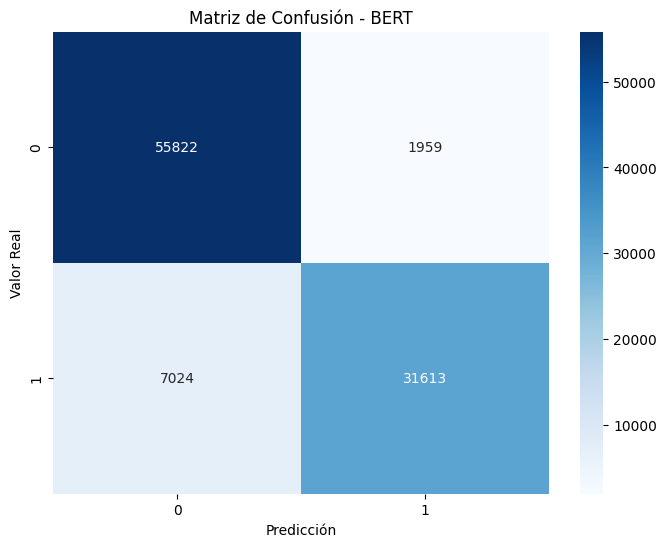

In [13]:
# 4. BERT
print("Generando embeddings BERT...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_train_bert = np.array([get_bert_embedding(doc) for doc in X_train])
X_test_bert = np.array([get_bert_embedding(doc) for doc in X_test])

bert_clf = RandomForestClassifier(n_estimators=100, random_state=42)
bert_clf.fit(X_train_bert, y_train)
y_pred_bert = bert_clf.predict(X_test_bert)
evaluate_model(y_test, y_pred_bert, "BERT")


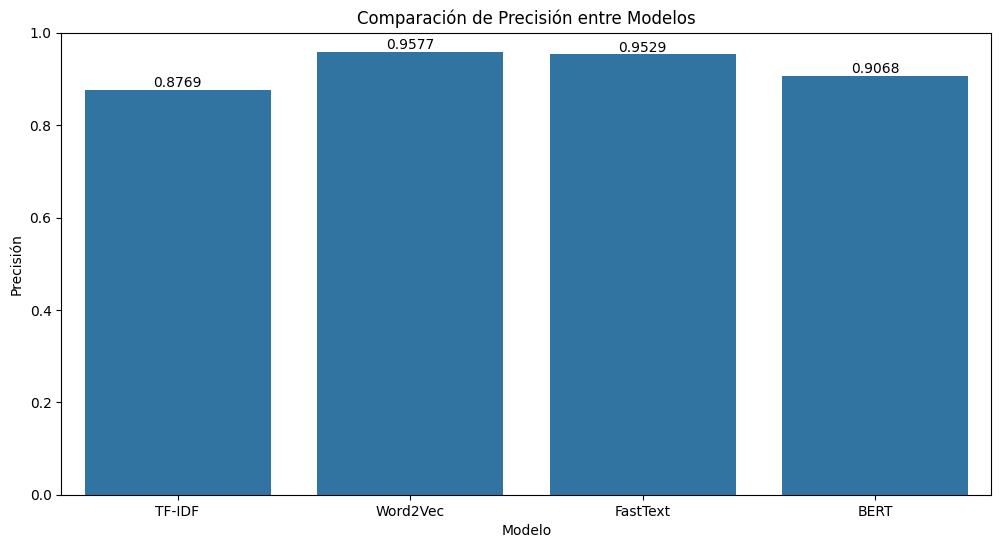

Resumen de resultados:
TF-IDF: 0.8769
Word2Vec: 0.9577
FastText: 0.9529
BERT: 0.9068


In [14]:
# Comparación de resultados
models = ['TF-IDF', 'Word2Vec', 'FastText', 'BERT']
accuracies = [
    tfidf_model.score(X_test_tfidf, y_test),
    w2v_clf.score(X_test_w2v, y_test),
    fasttext_clf.score(X_test_fasttext, y_test),
    bert_clf.score(X_test_bert, y_test)
]
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Comparación de Precisión entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()
print("Resumen de resultados:")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.4f}")


- Los resultados muestran que Word2Vec (95.77%) y FastText (95.29%) superan significativamente a TF-IDF (87.69%) y BERT (90.68%) en la clasificación de texto lematizado sin stopwords. Esto sugiere que las representaciones vectoriales de palabras capturan eficazmente las características relevantes para esta tarea específica. El rendimiento inferior de BERT se atribuye probablemente al preprocesamiento del texto, que elimina información contextual que BERT normalmente aprovecha.

- Dado estos resultados y considerando que BERT es considerablemente más lento para entrenar, se opta por quedarse con Word2Vec y FastText como los métodos preferidos para este proyecto. 



# 2. Seleccion del modelo

- En esta sección, compararemos tres modelos de clasificación basados en árboles: Random Forest, XGBoost y LightGBM. Estos modelos, aunque comparten la base de árboles de decisión, difieren en su enfoque de construcción y optimización. Random Forest utiliza el bagging para crear múltiples árboles independientes, lo que lo hace robusto contra el sobreajuste pero potencialmente menos preciso en problemas complejos. XGBoost emplea el boosting secuencial con regularización, lo que suele resultar en un rendimiento superior pero con mayor costo computacional. LightGBM, por su parte, utiliza el crecimiento de árbol por hoja, lo que lo hace más rápido y eficiente en memoria, pero potencialmente más propenso al sobreajuste en datasets pequeños. Teóricamente, XGBoost podría ofrecer el mejor rendimiento debido a su capacidad para capturar relaciones complejas, pero LightGBM podría ser más eficiente en términos de tiempo de entrenamiento. La elección final dependerá del equilibrio entre precisión, velocidad y las características específicas de nuestro conjunto de datos de textos tóxicos.


In [16]:
# Función para obtener el vector de documento
def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluación del modelo {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()




In [17]:
# Preparar los datos
X = df['lemmatized_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizar las oraciones
X_train_tokens = [word_tokenize(text.lower()) for text in tqdm(X_train, desc="Tokenizando datos de entrenamiento")]
X_test_tokens = [word_tokenize(text.lower()) for text in tqdm(X_test, desc="Tokenizando datos de prueba")]


Tokenizando datos de prueba: 100%|██████████████████████████████████████| 96418/96418 [00:04<00:00, 21620.97it/s]


In [18]:

# Generar embeddings Word2Vec
print("Generando embeddings Word2Vec...")
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
X_train_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_train_tokens, desc="Vectorizando datos de entrenamiento")])
X_test_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_test_tokens, desc="Vectorizando datos de prueba")])


Generando embeddings Word2Vec...


Vectorizando datos de prueba: 100%|█████████████████████████████████████| 96418/96418 [00:02<00:00, 42362.70it/s]



Entrenando Random Forest...
Evaluación del modelo Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     57781
           1       0.97      0.92      0.94     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.95     96418
weighted avg       0.96      0.96      0.96     96418



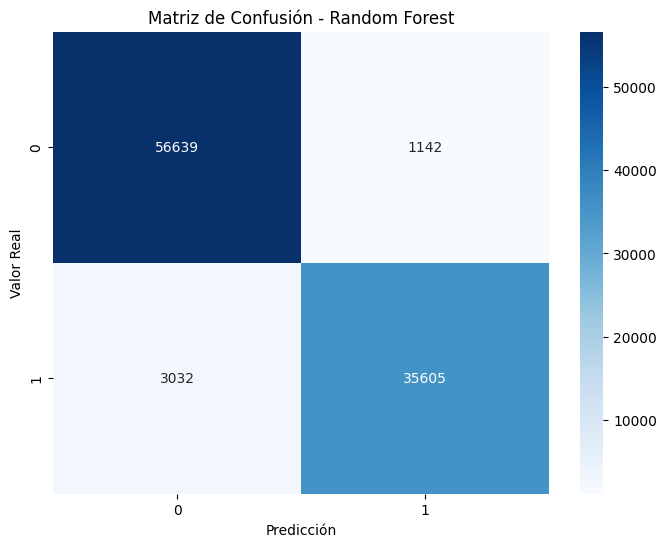


Entrenando XGBoost...
Evaluación del modelo XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.96      0.96     96418
weighted avg       0.96      0.96      0.96     96418



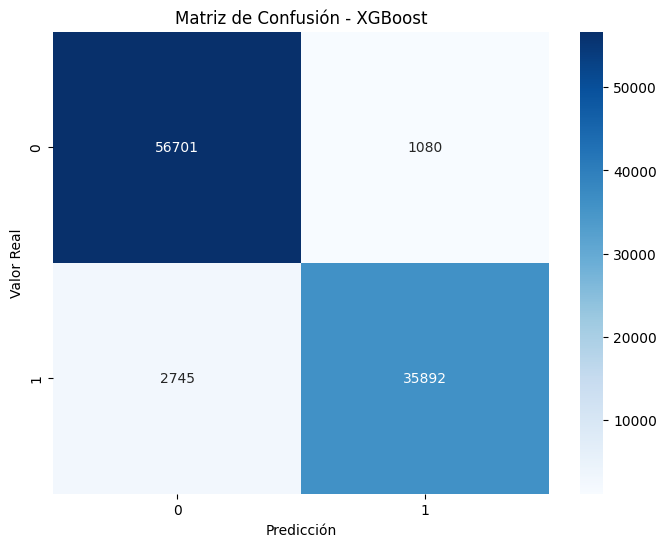


Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 154081, number of negative: 231587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 385668, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399517 -> initscore=-0.407477
[LightGBM] [Info] Start training from score -0.407477
Evaluación del modelo LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     96418



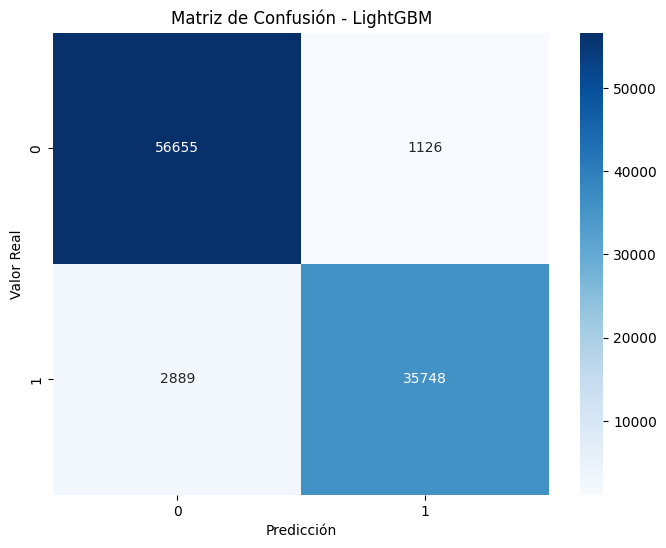

In [23]:

# Comparar modelos
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_w2v, y_train)
    y_pred = model.predict(X_test_w2v)
    evaluate_model(y_test, y_pred, name)


In [24]:

# Comparación de tiempos de ejecución (opcional)
from time import time

print("\nComparación de tiempos de ejecución:")
for name, model in models.items():
    start_time = time()
    model.fit(X_train_w2v, y_train)
    train_time = time() - start_time
    
    start_time = time()
    model.predict(X_test_w2v)
    predict_time = time() - start_time
    
    print(f"{name}:")
    print(f"  Tiempo de entrenamiento: {train_time:.2f} segundos")
    print(f"  Tiempo de predicción: {predict_time:.2f} segundos")


Comparación de tiempos de ejecución:
Random Forest:
  Tiempo de entrenamiento: 568.59 segundos
  Tiempo de predicción: 0.84 segundos
XGBoost:
  Tiempo de entrenamiento: 1.90 segundos
  Tiempo de predicción: 0.02 segundos
[LightGBM] [Info] Number of positive: 154081, number of negative: 231587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 385668, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399517 -> initscore=-0.407477
[LightGBM] [Info] Start training from score -0.407477
LightGBM:
  Tiempo de entrenamiento: 1.97 segundos
  Tiempo de predicción: 0.04 segundos


# Conclusiones:

- XGBoost y LightGBM emergen como los dos mejores modelos para nuestro análisis comparativo, considerando tanto el rendimiento como la eficiencia computacional.
- Random Forest, a pesar de tener un rendimiento comparable, queda descartado debido a sus tiempos de ejecución significativamente más largos, lo que lo hace menos práctico para este caso de uso.
- La diferencia en rendimiento entre XGBoost y LightGBM es mínima, lo que sugiere que ambos son igualmente capaces de capturar las características relevantes para la detección de textos tóxicos.
- La eficiencia computacional de XGBoost y LightGBM los hace más adecuados para escenarios donde se requieren reentrenamientos frecuentes o procesamiento de grandes volúmenes de datos.



Tokenizando datos de prueba: 100%|██████████████████████████████████████| 96418/96418 [00:04<00:00, 21532.16it/s]


Generando embeddings Word2Vec...


Vectorizando datos de prueba: 100%|█████████████████████████████████████| 96418/96418 [00:02<00:00, 42188.12it/s]



Entrenando XGBoost...
Evaluación del modelo XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.96      0.96     96418
weighted avg       0.96      0.96      0.96     96418



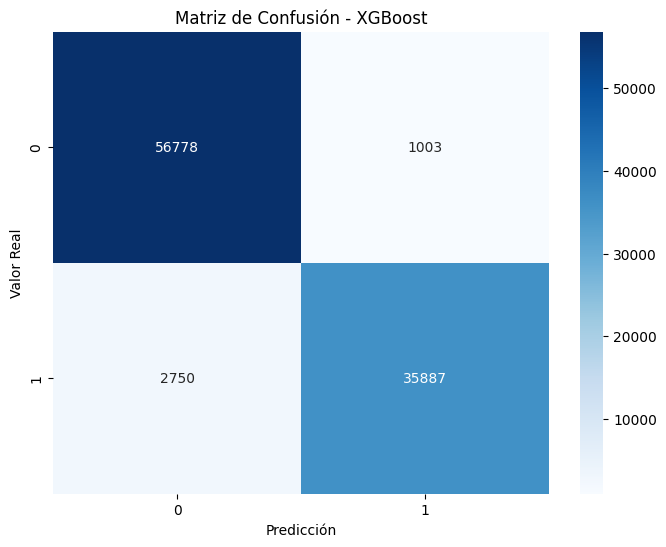

Tiempo de entrenamiento: 1.93 segundos
Tiempo de predicción: 0.02 segundos

Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 154081, number of negative: 231587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25506
[LightGBM] [Info] Number of data points in the train set: 385668, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399517 -> initscore=-0.407477
[LightGBM] [Info] Start training from score -0.407477
Evaluación del modelo LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.92      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     96418



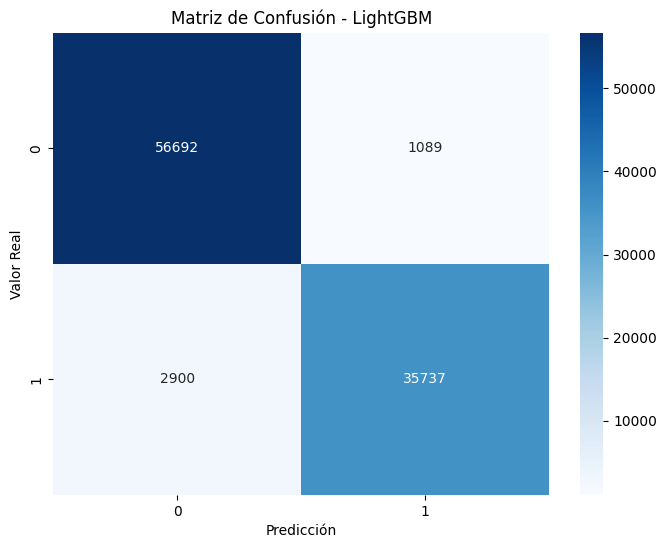

Tiempo de entrenamiento: 1.95 segundos
Tiempo de predicción: 0.04 segundos


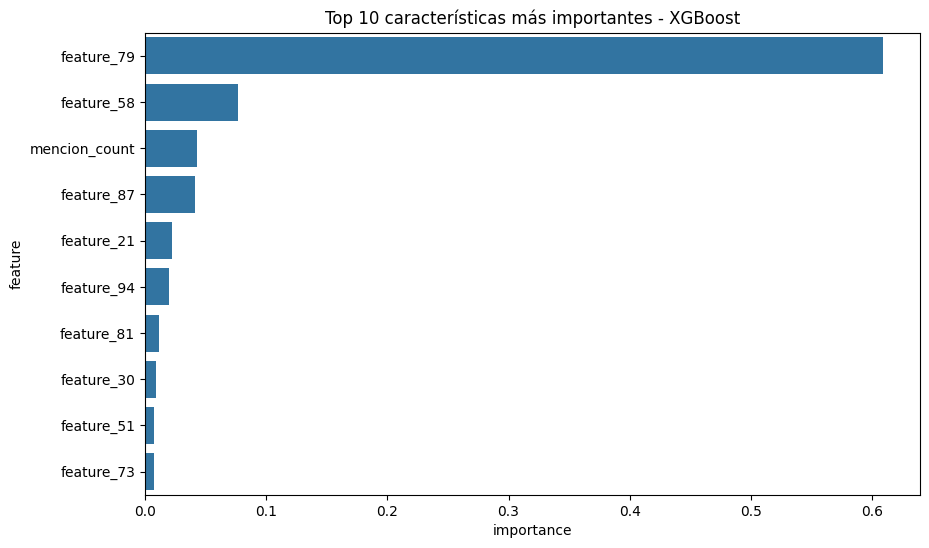

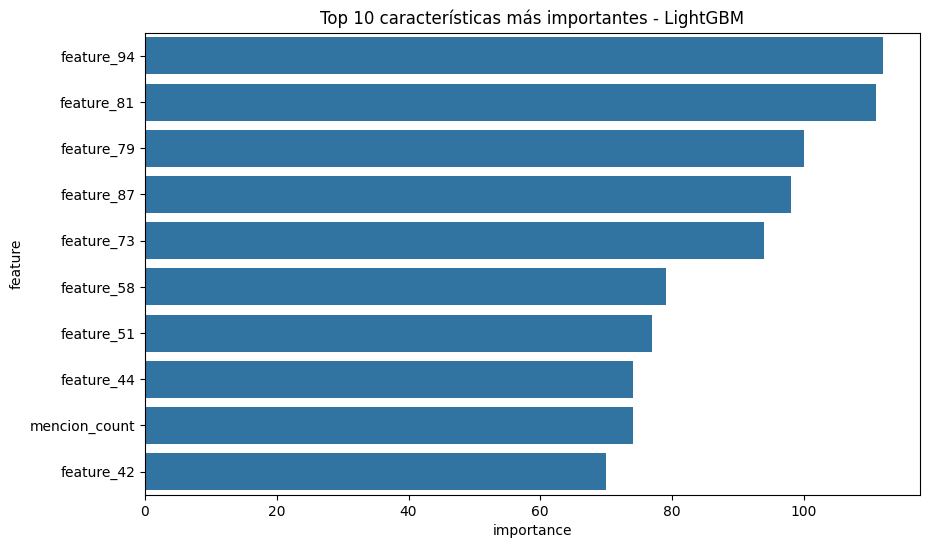

In [26]:


# Cargar los datos
df = pd.read_csv('../data/processed/data_toxic_features.csv')

# Función para obtener el vector de documento
def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluación del modelo {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

# Preparar los datos
X = df['lemmatized_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizar las oraciones
X_train_tokens = [word_tokenize(text.lower()) for text in tqdm(X_train, desc="Tokenizando datos de entrenamiento")]
X_test_tokens = [word_tokenize(text.lower()) for text in tqdm(X_test, desc="Tokenizando datos de prueba")]

# Generar embeddings Word2Vec
print("Generando embeddings Word2Vec...")
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
X_train_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_train_tokens, desc="Vectorizando datos de entrenamiento")])
X_test_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_test_tokens, desc="Vectorizando datos de prueba")])

# Añadir la característica mencion_count
X_train_w2v = np.column_stack((X_train_w2v, df.loc[X_train.index, 'mencion_count'].values))
X_test_w2v = np.column_stack((X_test_w2v, df.loc[X_test.index, 'mencion_count'].values))

# Comparar modelos
models = {
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    start_time = time.time()
    model.fit(X_train_w2v, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test_w2v)
    predict_time = time.time() - start_time
    
    evaluate_model(y_test, y_pred, name)
    
    print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

# Importancia de características
for name, model in models.items():
    feature_importance = model.feature_importances_
    feature_names = [f'feature_{i}' for i in range(100)] + ['mencion_count']
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f'Top 10 características más importantes - {name}')
    plt.show()

- La inclusión de mencion_count no parece haber producido una mejora significativa en el rendimiento general de los modelos comparado con los resultados anteriores.
- Esto podría sugerir que la información capturada por mencion_count ya estaba siendo representada de alguna manera por los embeddings de Word2Vec.

Tokenizando datos de prueba: 100%|██████████████████████████████████████| 96418/96418 [00:04<00:00, 21928.15it/s]


Generando embeddings Word2Vec...


Vectorizando datos de prueba: 100%|█████████████████████████████████████| 96418/96418 [00:02<00:00, 42106.08it/s]



Entrenando XGBoost...
Evaluación del modelo XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.96      0.96     96418
weighted avg       0.96      0.96      0.96     96418



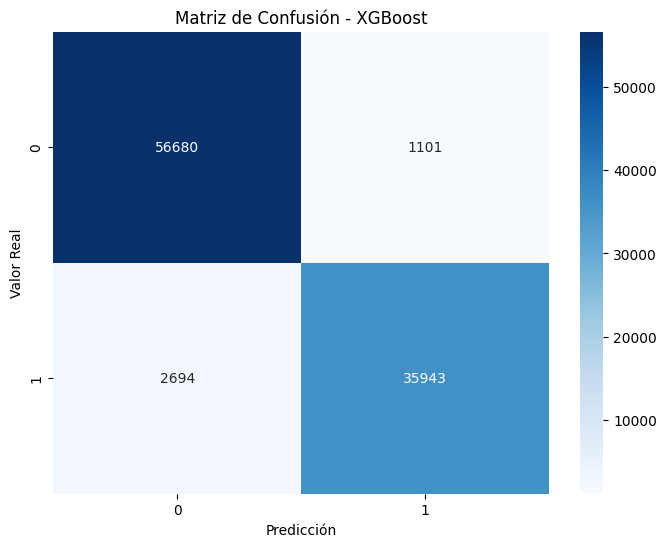

Errores guardados en: ../data/errors_xgboost.csv
Tiempo de entrenamiento: 1.94 segundos
Tiempo de predicción: 0.02 segundos

Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 154081, number of negative: 231587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25506
[LightGBM] [Info] Number of data points in the train set: 385668, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399517 -> initscore=-0.407477
[LightGBM] [Info] Start training from score -0.407477
Evaluación del modelo LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57781
           1       0.97      0.93      0.95     38637

    accuracy                           0.96     96418
   macro avg       0.96      0.95      0.96     96418
weighted avg       0.96      0.96      0.96     9

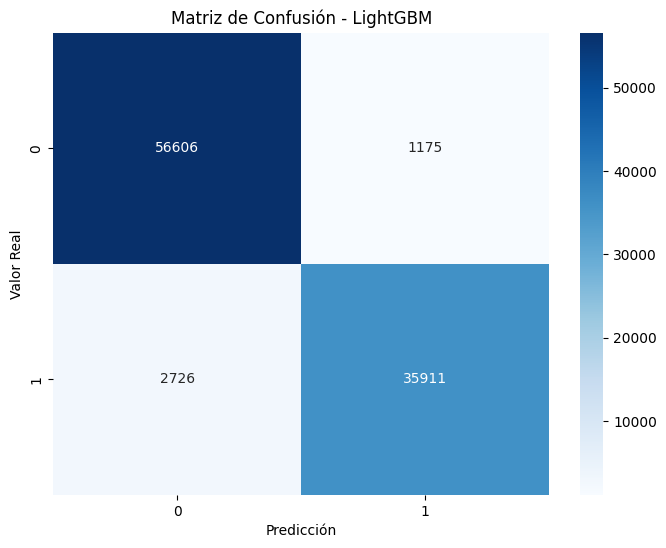

Errores guardados en: ../data/errors_lightgbm.csv
Tiempo de entrenamiento: 1.93 segundos
Tiempo de predicción: 0.04 segundos

Número de errores comunes: 3374

Ejemplos de errores comunes:
                                  lemmatized_message  ofensivas_count  \
0  waseem akhtar nominacion eliminacion rapido es...                0   
1                                  hola mismo prueba                0   
2  todavia poder creer casey real sonar demasiado...                1   
3            simplemente significar alguien notar td                0   
4  pensar exactamente existir objeto inamovible f...                0   

   true_label  predicted_label_x  predicted_label_y  
0           1                  0                  0  
1           1                  0                  0  
2           0                  1                  1  
3           1                  0                  0  
4           1                  0                  0  

Análisis de errores para XGBoost:
Total de error

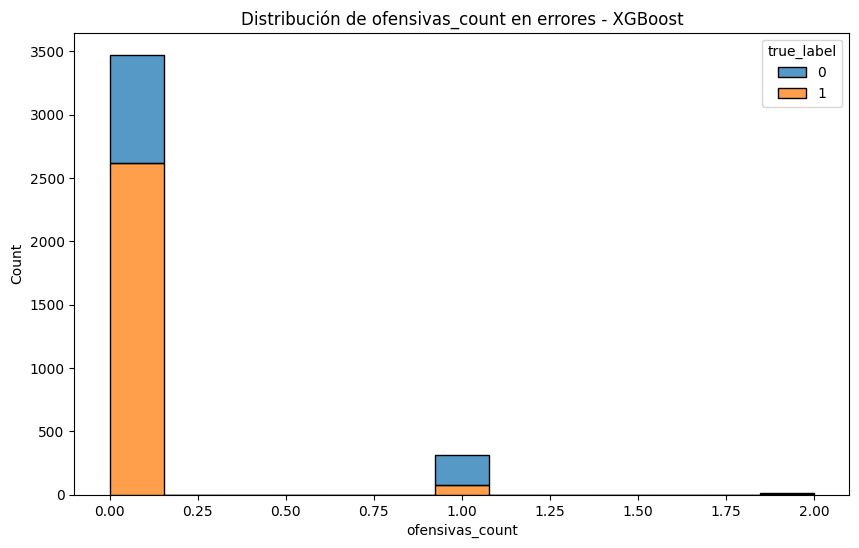


Análisis de errores para LightGBM:
Total de errores: 3901

Distribución de errores por clase:
true_label  predicted_label
0           1                  1175
1           0                  2726
dtype: int64

Estadísticas de ofensivas_count en errores:
count    3901.000000
mean        0.087926
std         0.292137
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ofensivas_count, dtype: float64


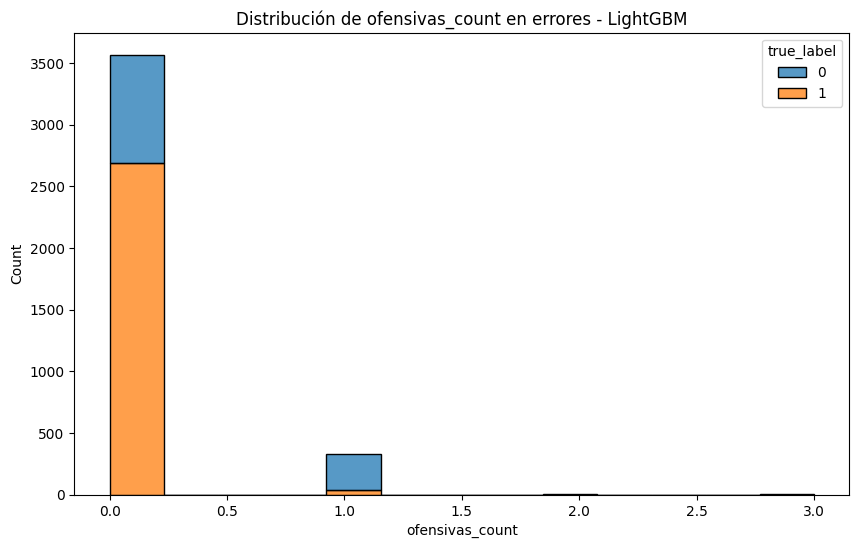

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os

# Cargar los datos
df = pd.read_csv('../data/processed/data_toxic_features.csv')

# Función para obtener el vector de documento
def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Función para evaluar el modelo y guardar los errores
def evaluate_model_and_save_errors(y_true, y_pred, X_test, model_name):
    print(f"Evaluación del modelo {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Crear un DataFrame con los errores
    errors_df = X_test[y_true != y_pred].copy()
    errors_df['true_label'] = y_true[y_true != y_pred]
    errors_df['predicted_label'] = y_pred[y_true != y_pred]
    
    # Guardar los errores en un archivo CSV
    output_path = f'../data/errors_{model_name.lower()}.csv'
    errors_df.to_csv(output_path, index=False)
    print(f"Errores guardados en: {output_path}")
    
    return errors_df

# Preparar los datos
X = df[['lemmatized_message', 'ofensivas_count']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizar las oraciones
X_train_tokens = [word_tokenize(text.lower()) for text in tqdm(X_train['lemmatized_message'], desc="Tokenizando datos de entrenamiento")]
X_test_tokens = [word_tokenize(text.lower()) for text in tqdm(X_test['lemmatized_message'], desc="Tokenizando datos de prueba")]

# Generar embeddings Word2Vec
print("Generando embeddings Word2Vec...")
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
X_train_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_train_tokens, desc="Vectorizando datos de entrenamiento")])
X_test_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in tqdm(X_test_tokens, desc="Vectorizando datos de prueba")])

# Añadir la característica ofensivas_count
X_train_w2v = np.column_stack((X_train_w2v, X_train['ofensivas_count'].values))
X_test_w2v = np.column_stack((X_test_w2v, X_test['ofensivas_count'].values))

# Comparar modelos
models = {
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

all_errors = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    start_time = time.time()
    model.fit(X_train_w2v, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test_w2v)
    predict_time = time.time() - start_time
    
    errors_df = evaluate_model_and_save_errors(y_test, y_pred, X_test, name)
    all_errors[name] = errors_df
    
    print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

# Analizar errores comunes
common_errors = pd.merge(all_errors['XGBoost'], all_errors['LightGBM'], how='inner', on=['lemmatized_message', 'ofensivas_count', 'true_label'])
common_errors = common_errors[common_errors['predicted_label_x'] == common_errors['predicted_label_y']]

print(f"\nNúmero de errores comunes: {len(common_errors)}")
print("\nEjemplos de errores comunes:")
print(common_errors.head())

# Análisis adicional de errores
def analyze_errors(errors_df, model_name):
    print(f"\nAnálisis de errores para {model_name}:")
    print(f"Total de errores: {len(errors_df)}")
    print("\nDistribución de errores por clase:")
    print(errors_df.groupby(['true_label', 'predicted_label']).size())
    
    print("\nEstadísticas de ofensivas_count en errores:")
    print(errors_df['ofensivas_count'].describe())
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=errors_df, x='ofensivas_count', hue='true_label', multiple='stack')
    plt.title(f'Distribución de ofensivas_count en errores - {model_name}')
    plt.show()

for name, errors in all_errors.items():
    analyze_errors(errors, name)


In [33]:
# Guardar el modelo Word2Vec
print("Guardando modelo Word2Vec...")
joblib.dump(w2v_model, '../models/w2v_model.joblib')

Guardando modelo Word2Vec...


['../models/w2v_model.joblib']

# Rendimiento general:
## Ambos modelos (XGBoost y LightGBM) muestran un rendimiento muy bueno, con una precisión global del 96% en ambos casos.

## Optimización de Hiperparámetros con Validación Cruzada

En este proceso de optimización de hiperparámetros, utilizamos la técnica de validación cruzada (CV) con 5 folds para asegurar la robustez y generalización de los modelos.
- Al dividir los datos en múltiples folds y entrenar el modelo en diferentes combinaciones de estos, podemos obtener una estimación más confiable del rendimiento del modelo en datos no vistos. Esto ayuda a prevenir el overfitting, ya que comprueba que su rendimiento sea consistente a través de diferentes muestras. 
- La validación cruzada permite aprovechar al máximo los datos de entrenamiento, ya que proporciona una medida más estable del rendimiento del modelo, lo que permite seleccionar los hiperparámetros que realmente optimizan la capacidad de generalización de los modelos de detección de textos tóxicos.

In [34]:
# Cargar los datos
df = pd.read_csv('../data/processed/data_toxic_features.csv')

# Preparar los datos
X = df[['lemmatized_message', 'ofensivas_count']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función para obtener el vector de documento (asumiendo que ya tienes el modelo Word2Vec entrenado)
def get_doc_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Cargar el modelo Word2Vec (asegúrate de que esté guardado previamente)
w2v_model = joblib.load('../models/w2v_model.joblib')

# Vectorizar los datos
print("Vectorizando datos...")
X_train_w2v = np.array([get_doc_vector(doc.split(), w2v_model) for doc in tqdm(X_train['lemmatized_message'])])
X_test_w2v = np.array([get_doc_vector(doc.split(), w2v_model) for doc in tqdm(X_test['lemmatized_message'])])

# Añadir la característica ofensivas_count
X_train_w2v = np.column_stack((X_train_w2v, X_train['ofensivas_count'].values))
X_test_w2v = np.column_stack((X_test_w2v, X_test['ofensivas_count'].values))

# Definir espacios de búsqueda de hiperparámetros
xgb_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

lgb_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(1, 50),
    'num_leaves': randint(20, 100)
}

# Función para optimizar hiperparámetros
def optimize_hyperparameters(model, param_dist, X_train, y_train, n_iter=100):
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=n_iter, 
        scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=42
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

# Optimizar XGBoost
print("Optimizando XGBoost...")
start_time = time.time()
xgb_best, xgb_best_params, xgb_best_score = optimize_hyperparameters(
    XGBClassifier(random_state=42), xgb_param_dist, X_train_w2v, y_train
)
xgb_time = time.time() - start_time

# Optimizar LightGBM
print("Optimizando LightGBM...")
start_time = time.time()
lgb_best, lgb_best_params, lgb_best_score = optimize_hyperparameters(
    LGBMClassifier(random_state=42), lgb_param_dist, X_train_w2v, y_train
)
lgb_time = time.time() - start_time

# Evaluar los modelos optimizados
xgb_pred = xgb_best.predict(X_test_w2v)
lgb_pred = lgb_best.predict(X_test_w2v)

xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')
lgb_f1 = f1_score(y_test, lgb_pred, average='weighted')

# Imprimir resultados
print("\nResultados de la optimización:")
print(f"XGBoost - Mejores parámetros: {xgb_best_params}")
print(f"XGBoost - Mejor F1-score (validación): {xgb_best_score:.4f}")
print(f"XGBoost - F1-score (test): {xgb_f1:.4f}")
print(f"XGBoost - Tiempo de optimización: {xgb_time:.2f} segundos")

print(f"\nLightGBM - Mejores parámetros: {lgb_best_params}")
print(f"LightGBM - Mejor F1-score (validación): {lgb_best_score:.4f}")
print(f"LightGBM - F1-score (test): {lgb_f1:.4f}")
print(f"LightGBM - Tiempo de optimización: {lgb_time:.2f} segundos")

# Guardar los modelos optimizados
os.makedirs('../models', exist_ok=True)
joblib.dump(xgb_best, '../models/xgb_optimized.joblib')
joblib.dump(lgb_best, '../models/lgb_optimized.joblib')
print("\nModelos optimizados guardados en la carpeta 'models'.")

Vectorizando datos...


100%|███████████████████████████████████████████████████████████████████| 96418/96418 [00:02<00:00, 42518.33it/s]


Optimizando XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimizando LightGBM...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 154081, number of negative: 231587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25506
[LightGBM] [Info] Number of data points in the train set: 385668, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399517 -> initscore=-0.407477
[LightGBM] [Info] Start training from score -0.407477

Resultados de la optimización:
XGBoost - Mejores parámetros: {'colsample_bytree': 0.7123738038749523, 'gamma': 0.27134804157912423, 'learning_rate': 0.052277267492428794, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 956, 'subsample': 0.9947547746402069}
XGBoost - Mejor F1-score (validación): 0.9489
XGBoost - F1-scor

## Conclusiones

Tanto XGBoost como LightGBM alcanzaron un rendimiento muy bueno, con F1-scores superiores al 95% en el conjunto de prueba. XGBoost mostró una ligera ventaja en términos de precisión (F1-score de 0.9594 vs 0.9589 de LightGBM) y eficiencia computacional. La similitud en el rendimiento sugiere que ambos modelos son igualmente capaces de capturar las características relevantes para la detección de toxicidad. Estos resultados indican que nuestra combinación de embeddings de Word2Vec y características engineered (como el conteo de palabras ofensivas) proporciona una base sólida para la clasificación. 
- Para futuras mejoras, podríamos considerar técnicas de ensamblaje o un análisis más profundo de los casos de error restantes.